In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/gold-xauusd-prediction-and-forcast-using-arima/CleanedData.xlsx


# Importing the required libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pyplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf, pacf
from datetime import datetime
from datetime import timedelta
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
import seaborn as sns

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import warnings
warnings.filterwarnings("ignore")

# Loading the data

This code reads in a CSV file of gold price data, parses the dates in the first column using the parser function, and creates a sorted pandas DataFrame from the data.

In [4]:
#loading the data
df_data = pd.read_excel('/kaggle/input/gold-xauusd-prediction-and-forcast-using-arima/CleanedData.xlsx', header=0, index_col=0)
df_data

,Open,High,Low,Close,Change(Pips),Change(%)
Date,,,,,,
2021-07-04,1787.22,1787.73,1785.00,1786.39,-83,-0.05
2021-07-05,1786.68,1794.00,1783.80,1791.15,447,0.25
2021-07-06,1790.85,1814.89,1789.89,1795.68,483,0.27
2021-07-07,1795.28,1809.50,1793.41,1803.22,794,0.44
2021-07-08,1803.29,1818.00,1793.90,1803.75,46,0.03
...,...,...,...,...,...,...
2023-06-29,1909.47,1913.00,1893.16,1908.76,-71,-0.04
2023-06-30,1908.71,1922.61,1900.57,1919.20,1049,0.55
2023-07-02,1920.30,1920.30,1917.50,1917.70,-260,-0.14


# Preprocessing

This code performs data cleaning and preprocessing on the df_data DataFrame. It fills the zero and missing values and Finally, it drops any duplicate rows in the DataFrame.

In [5]:
df_data.replace(to_replace=0,method='ffill',inplace=True)
df_data.fillna(method='ffill',inplace=True)
df_data.replace(to_replace=0,method='bfill',inplace=True) #zeros
df_data.fillna(method='bfill',inplace=True)
df_data = df_data.drop_duplicates()
df_data

,Open,High,Low,Close,Change(Pips),Change(%)
Date,,,,,,
2021-07-04,1787.22,1787.73,1785.00,1786.39,-83,-0.05
2021-07-05,1786.68,1794.00,1783.80,1791.15,447,0.25
2021-07-06,1790.85,1814.89,1789.89,1795.68,483,0.27
2021-07-07,1795.28,1809.50,1793.41,1803.22,794,0.44
2021-07-08,1803.29,1818.00,1793.90,1803.75,46,0.03
...,...,...,...,...,...,...
2023-06-29,1909.47,1913.00,1893.16,1908.76,-71,-0.04
2023-06-30,1908.71,1922.61,1900.57,1919.20,1049,0.55
2023-07-02,1920.30,1920.30,1917.50,1917.70,-260,-0.14


# Visulizing

Here we generate a line plot of the daily closing price of gold over time using the matplotlib library.

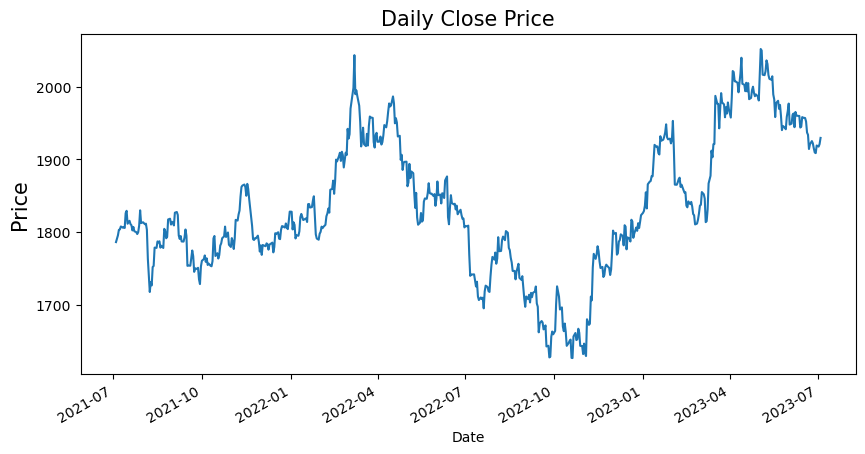

In [6]:
#plotting daily close price
fig = plt.figure(figsize=(10, 5))
plt.title('Daily Close Price', fontsize=15)
plt.ylabel('Price', fontsize=15)
df_data['Close'].plot()
plt.show()

This code calculates and plots the first difference of the daily closing price of gold over time using the matplotlib library.
The diff method is used to calculate the difference between consecutive values in the 'Close' column of the df_data DataFrame.

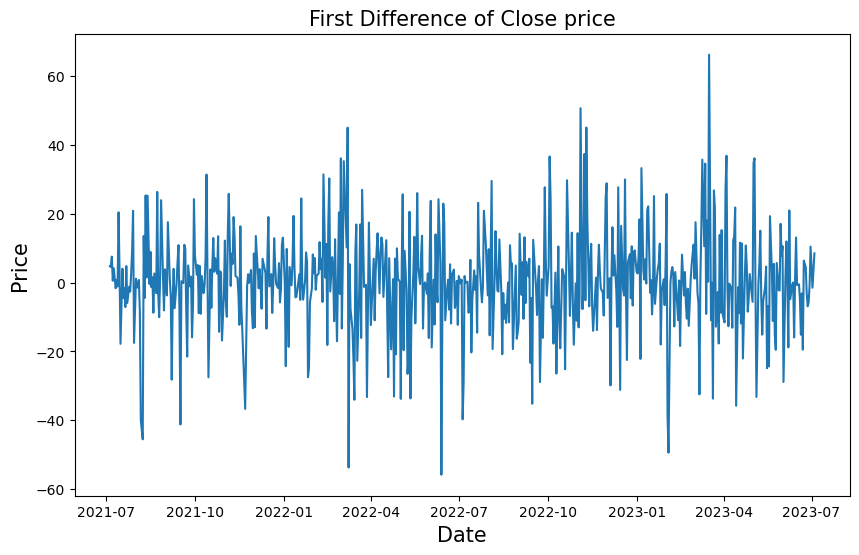

In [7]:
#plotting and calculating first difference
first_difference = df_data['Close'].diff()[1:]
fig = plt.figure(figsize=(10, 6))
plt.title('First Difference of Close price', fontsize=15)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.plot(first_difference)

Here we generate an autocorrelation function (ACF) plot of the first difference of the daily closing price of gold over time using the matplotlib and pandas libraries.

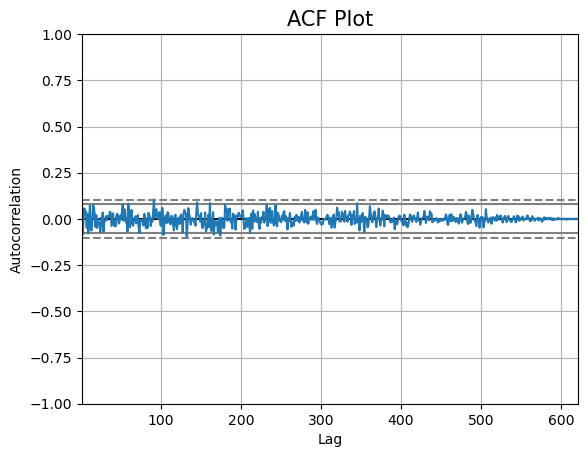

In [8]:
#plotting ACF
plt.title('ACF Plot', fontsize=15)
autocorrelation_plot(first_difference)
pyplot.show()

In this cell we generate a partial autocorrelation function (PACF) plot of the first difference of the daily closing price of gold over time using the statsmodels library.

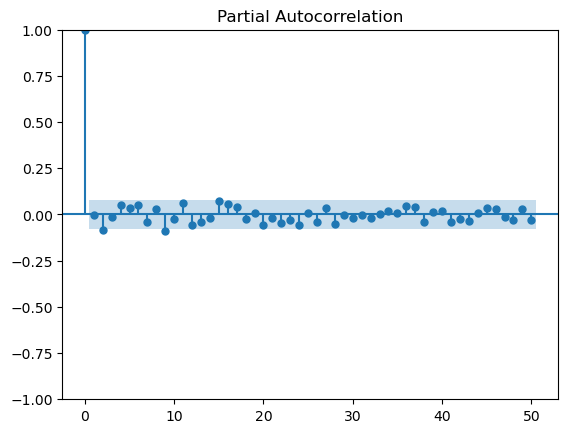

In [9]:
#plotting PACF
pacf_plot=plot_pacf(first_difference,lags=50)

# pearson correlation

In this cell we are creating a correlation matrix heatmap for a set of lagged time series data.

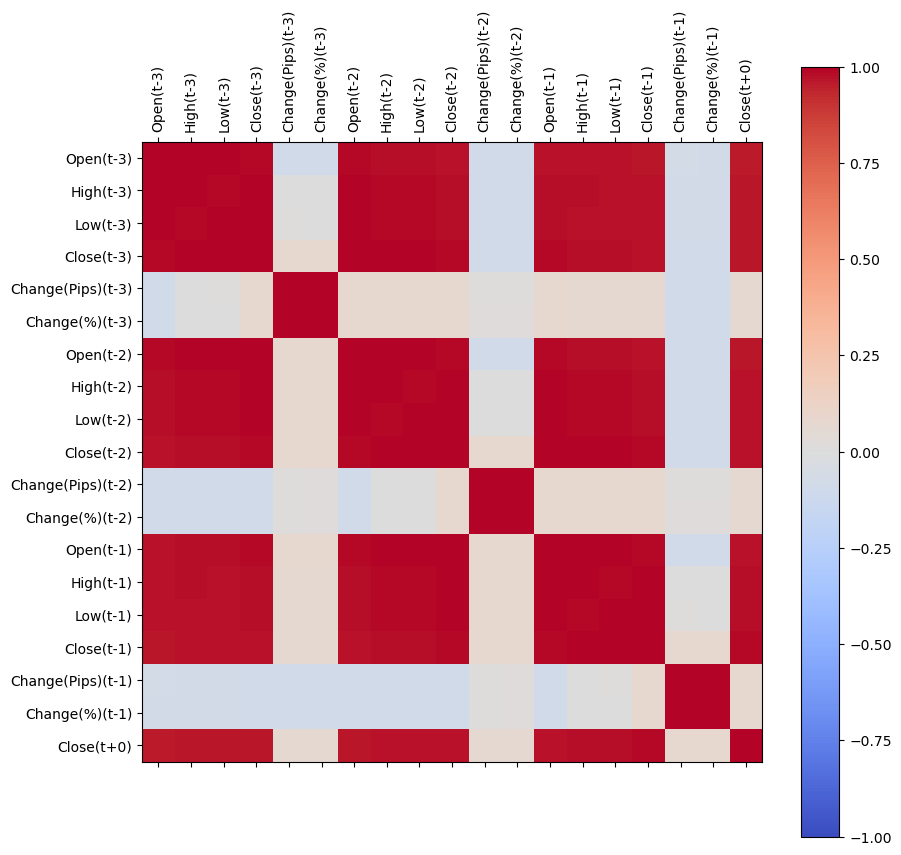

In [10]:
predictname='Close'
n1=3
n_vars=len(df_data.columns)
cols, names = list(), list()
for i in range(n1, 0, -1):
    cols.append(df_data.shift(i))
    names += [( '%s(t-%d)'%(df_data.columns[j],i)) for j in range(n_vars)]
n2=0
cols.append(df_data[predictname].shift(-n2))
names += [ '%s(t+%d)'%(predictname,n2)]
agg = pd.concat(cols, axis=1)
agg.columns = names
corr = agg.corr()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(agg.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(agg.columns)
ax.set_yticklabels(agg.columns)
plt.show()

# Splitting the data

In [11]:
#splitting the data
num_split=int(df_data['Close'].shape[0]*0.8)
train_set=df_data['Close'].iloc[:num_split]
test_set=df_data['Close'].iloc[num_split:]
test_set

Date
2023-02-08    1874.97
2023-02-09    1862.23
2023-02-10    1865.28
2023-02-13    1854.34
2023-02-14    1854.94
               ...   
2023-06-29    1908.76
2023-06-30    1919.20
2023-07-02    1917.70
2023-07-03    1921.17
2023-07-04    1929.65
Name: Close, Length: 125, dtype: float64

# Optimal ARIMA model

In the next three cells we install the pmdarima library using pip, import it as pm, and fit an ARIMA model to the train_set dataset using the auto_arima function from pmdarima and then we print the results.
The auto_arima function is used to automatically select the optimal ARIMA model parameters based on the provided data.

In [12]:
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 33.1 MB/s eta 0:00:00


In [13]:
import pmdarima as pm
model = pm.auto_arima(train_set, start_p=0, start_q=0, start_order=0, max_p=10 ,max_q=10, max_order=10, test='adf', stepwise=False, trace=True, seasonal=False)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4068.747, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4070.747, Time=0.21 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=4067.737, Time=0.34 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=4067.218, Time=0.69 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=4068.410, Time=0.82 sec
 ARIMA(0,1,5)(0,0,0)[0] intercept   : AIC=4070.107, Time=0.95 sec
 ARIMA(0,1,6)(0,0,0)[0] intercept   : AIC=4071.488, Time=0.87 sec
 ARIMA(0,1,7)(0,0,0)[0] intercept   : AIC=4070.820, Time=1.43 sec
 ARIMA(0,1,8)(0,0,0)[0] intercept   : AIC=4072.308, Time=1.83 sec
 ARIMA(0,1,9)(0,0,0)[0] intercept   : AIC=4071.500, Time=1.40 sec
 ARIMA(0,1,10)(0,0,0)[0] intercept   : AIC=4072.349, Time=2.23 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4070.747, Time=0.13 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=4070.269, Time=0.24 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4068.340, Time=0.50 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=4068.263, Time=0.70 sec
 ARIMA(1,

In [14]:
# Get the best order of the model
best_order = model.order

# Get the best model summary
best_model = model.arima_res_
best_model_summary = best_model.summary()

print('Best order:', best_order)
print('Best model summary:\n', best_model_summary)

Best order: (0, 1, 3)
Best model summary:
                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  497
Model:               SARIMAX(0, 1, 3)   Log Likelihood               -2028.609
Date:                Tue, 08 Aug 2023   AIC                           4067.218
Time:                        14:31:53   BIC                           4088.251
Sample:                             0   HQIC                          4075.474
                                - 497                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1739      0.651      0.267      0.789      -1.102       1.450
ma.L1          0.0040      0.040      0.099      0.921      -0.074       0.082
ma.L2    

# Prediction and evaluation

this code performs rolling prediction on the test_set dataset using the ARIMA model with the best_order previously selected by the auto_arima function.
Rolling prediction is a common technique used in time series forecasting to evaluate the performance of a model on a rolling basis.

In [15]:
#rolling forecast
rolling_pred = test_set.copy()
for split_num in test_set.index:
    train_set = df_data['Close'][:split_num-timedelta(days=1)]
    model = ARIMA(train_set, order=best_order)
    model_fit = model.fit()

    pred = model_fit.forecast()
    rolling_pred[split_num] = pred

here we calculate the rolling residuals of the rolling prediction and then we generate a plot of the residuals using the matplotlib library.

Text(0, 0.5, 'Error')

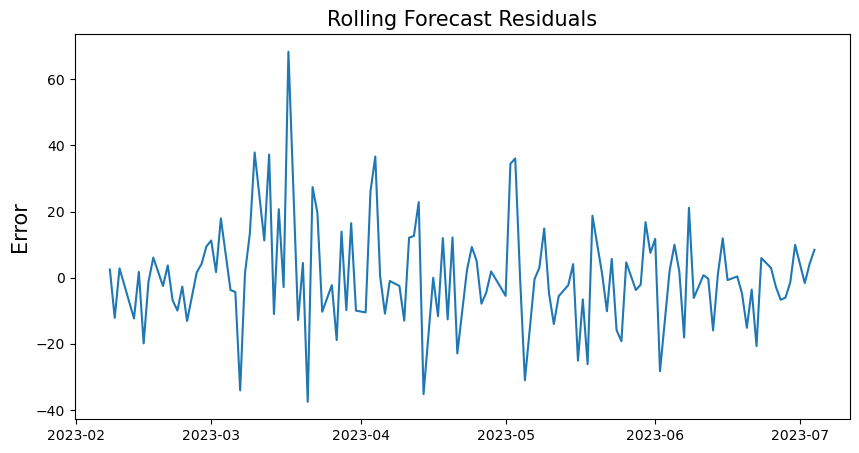

In [16]:
#calculating and plotting the residuals
rolling_residuals = test_set - rolling_pred
plt.figure(figsize=(10,5))
plt.plot(rolling_residuals)
plt.title('Rolling Forecast Residuals', fontsize=15)
plt.ylabel('Error', fontsize=15)

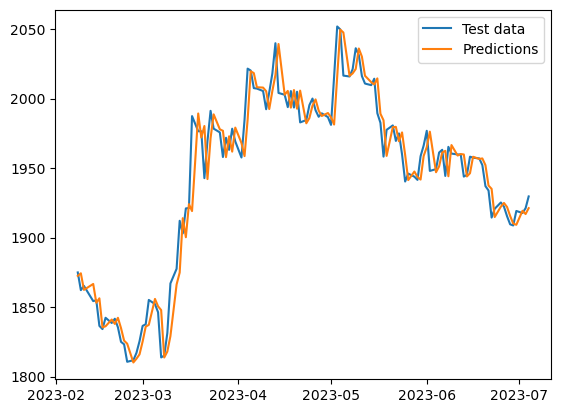

In [17]:
# Plot the test values and their predictions
plt.plot(test_set.index, test_set.values, label='Test data')
plt.plot(test_set.index, rolling_pred.values, label='Predictions')
plt.legend()
plt.show()

In [18]:
#evaluating the model
mse = mean_squared_error(test_set.values, rolling_pred.values)
print('MSE:', mse)
mape = mean_absolute_percentage_error(test_set.values, rolling_pred.values)
print('MAPE:', mape)

MSE: 247.84393787535282
MAPE: 0.005768216076678497
